# SOLA Complete Performance Profiling Study

## Overview

This notebook provides comprehensive performance profiling of the SOLA (Subtractive Optimally Localized Averages) method. We combine insights from basis function analysis and integration benchmarking to create a complete performance map. The study examines:

1. **End-to-End Profiling**: Complete timing breakdown of the SOLA pipeline
2. **Memory Usage Analysis**: Memory allocation patterns and peak usage
3. **Scalability Assessment**: How SOLA scales with problem size
4. **Bottleneck Identification**: Which operations limit performance
5. **Optimization Opportunities**: Recommendations for performance improvements

## Methodology

We use Python's built-in profiling tools combined with memory monitoring to provide detailed performance insights across different problem configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import cProfile
import pstats
import io
import psutil
import gc
import warnings
from collections import defaultdict
import os
from contextlib import contextmanager
from memory_profiler import profile

# PyGeoInf imports
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure

# Styling and output setup
sns.set_theme(style="whitegrid", palette="tab10")
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore', category=UserWarning)

# Create output directory
output_dir = 'sola_complete_profiling'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("SOLA Complete Performance Profiling Study")
print("=" * 50)

# System information
print("System Information:")
print(f"  CPU cores: {psutil.cpu_count()}")
print(f"  Available memory: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"  Python process PID: {os.getpid()}")

/home/adrian/miniconda3/envs/inferences3/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import gaussian_kde


SOLA Complete Performance Profiling Study
System Information:
  CPU cores: 16
  Available memory: 7.4 GB
  Python process PID: 16176


## Profiling Framework Setup

We establish a comprehensive profiling framework that captures both timing and memory usage at each step of the SOLA algorithm.

In [3]:
@contextmanager
def profile_section(name, profiler_dict):
    """Context manager for profiling individual sections."""
    process = psutil.Process()
    mem_start = process.memory_info().rss / 1024 / 1024  # MB
    time_start = time.time()

    yield

    time_end = time.time()
    mem_end = process.memory_info().rss / 1024 / 1024  # MB

    profiler_dict[name] = {
        'time': time_end - time_start,
        'memory_delta': mem_end - mem_start,
        'memory_start': mem_start,
        'memory_end': mem_end
    }

class SOLAProfiler:
    """Comprehensive SOLA performance profiler."""

    def __init__(self):
        self.detailed_profiles = {}
        self.results = []

    def create_synthetic_model(self, M, domain):
        """Create complex synthetic model for testing."""
        def model_func(x):
            envelope = np.exp(-((x - domain.center) / 0.4)**2)
            oscillation = np.sin(5 * np.pi * x)
            trend = 0.3 * x
            return envelope * oscillation + trend
        return Function(M, evaluate_callable=model_func)

    def profile_complete_sola(self, n_basis=30, basis_type='sine', n_data=50,
                             n_properties=20, integration_points=1000, noise_level=0.1):
        """Profile complete SOLA workflow with detailed timing."""

        # Initialize profiling
        sections = {}
        total_start = time.time()

        # Configuration info
        config = f"{basis_type}_N{n_basis}_I{integration_points}"

        # Step 1: Space creation
        with profile_section('space_creation', sections):
            domain = IntervalDomain(0, 1)
            M = L2Space(n_basis, domain, basis_type=basis_type)
            D = EuclideanSpace(n_data)
            P = EuclideanSpace(n_properties)

        # Step 2: Model creation
        with profile_section('model_creation', sections):
            m_bar = self.create_synthetic_model(M, domain)

        # Step 3: Forward operator
        with profile_section('forward_operator', sections):
            normal_modes_provider = NormalModesProvider(
                M, gaussian_width_percent_range=(5, 10),
                freq_range=(5, 10), random_state=39
            )
            G = SOLAOperator(M, D, normal_modes_provider,
                            integration_method='trapz', n_points=integration_points)

        # Step 4: Target operator
        with profile_section('target_operator', sections):
            width = 0.2
            centers = np.linspace(domain.a + width / 2, domain.b - width / 2, n_properties)
            target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
            T = SOLAOperator(M, P, target_provider,
                            integration_method='trapz', n_points=integration_points)

        # Step 5: Data generation
        with profile_section('data_generation', sections):
            np.random.seed(42)
            d_clean = G(m_bar)
            noise_std = noise_level * np.max(np.abs(d_clean))
            d_noisy = d_clean + np.random.normal(0, noise_std, d_clean.shape)

        # Step 6: Noise setup
        with profile_section('noise_setup', sections):
            C_D_matrix = noise_std**2 * np.eye(n_data)
            gaussian_D = GaussianMeasure.from_covariance_matrix(D, C_D_matrix, expectation=d_noisy)

        # Step 7: Gram matrix computation
        with profile_section('gram_matrix', sections):
            Lambda = G @ G.adjoint

        # Step 8: Linear solve
        with profile_section('linear_solve', sections):
            cholesky_solver = CholeskySolver(galerkin=True)
            W_inv = cholesky_solver(Lambda + gaussian_D.covariance)

        # Step 9: SOLA construction
        with profile_section('sola_construction', sections):
            G_inv = G.adjoint @ W_inv
            X = T @ G_inv

        # Step 10: Property inference
        with profile_section('property_inference', sections):
            property_measure = gaussian_D.affine_mapping(operator=X)
            p_estimated = property_measure.expectation
            p_true = T(m_bar)

        # Step 11: Accuracy computation
        with profile_section('accuracy_computation', sections):
            property_error = np.mean(np.abs(p_estimated - p_true))

        # Total timing
        total_time = time.time() - total_start
        sections['total_workflow'] = {
            'time': total_time,
            'memory_delta': sum(s.get('memory_delta', 0) for s in sections.values())
        }

        # Clean up large objects
        del G, T, Lambda, W_inv, G_inv, X, property_measure
        gc.collect()

        return {
            'config': config,
            'n_basis': n_basis,
            'basis_type': basis_type,
            'integration_points': integration_points,
            'sections': sections,
            'property_error': property_error
        }

    def profile_with_cprofile(self, n_basis=30, basis_type='sine'):
        """Execute detailed cProfile profiling."""

        # Setup cProfile
        profiler = cProfile.Profile()
        profiler.enable()

        # Execute SOLA workflow
        result = self.profile_complete_sola(n_basis=n_basis, basis_type=basis_type)

        profiler.disable()

        # Process results
        s = io.StringIO()
        ps = pstats.Stats(profiler, stream=s)
        ps.sort_stats('cumulative')
        ps.print_stats(20)  # Top 20 functions

        profile_name = f"{basis_type}_N{n_basis}"
        self.detailed_profiles[profile_name] = s.getvalue()

        return result

# Create profiler instance
profiler = SOLAProfiler()
print("SOLA profiling framework ready.")

SOLA profiling framework ready.


In [ ]:
# Test the profiling framework with a small example
print("Testing SOLA profiling framework...")
print("Running small test configuration...")

test_result = profiler.profile_complete_sola(
    n_basis=10,
    basis_type='sine',
    integration_points=500
)

print(f"✓ Test completed: {test_result['config']}")
print(f"  Total time: {test_result['sections']['total_workflow']['time']:.3f}s")
print(f"  Property error: {test_result['property_error']:.6f}")
print("\nSection timing breakdown:")
for section, data in test_result['sections'].items():
    if section != 'total_workflow':
        print(f"  {section}: {data['time']:.4f}s ({data['memory_delta']:+.1f}MB)")

Testing SOLA profiling framework...
Running small test configuration...
✓ Test completed: sine_N10_I500
  Total time: 1.447s
  Property error: 0.253053

Section timing breakdown:
  space_creation: 0.0001s (+0.0MB)
  model_creation: 0.0000s (+0.0MB)
  forward_operator: 0.0003s (+0.0MB)
  target_operator: 0.0001s (+0.0MB)
  data_generation: 0.0251s (+0.0MB)
  noise_setup: 0.0121s (+0.9MB)
  gram_matrix: 0.0000s (+0.0MB)
  linear_solve: 1.3033s (+2.0MB)
  sola_construction: 0.0000s (+0.0MB)
  property_inference: 0.1027s (+1.7MB)
  accuracy_computation: 0.0000s (+0.0MB)
✓ Test completed: sine_N10_I500
  Total time: 1.447s
  Property error: 0.253053

Section timing breakdown:
  space_creation: 0.0001s (+0.0MB)
  model_creation: 0.0000s (+0.0MB)
  forward_operator: 0.0003s (+0.0MB)
  target_operator: 0.0001s (+0.0MB)
  data_generation: 0.0251s (+0.0MB)
  noise_setup: 0.0121s (+0.9MB)
  gram_matrix: 0.0000s (+0.0MB)
  linear_solve: 1.3033s (+2.0MB)
  sola_construction: 0.0000s (+0.0MB)
  prop

## Comprehensive Performance Profiling

We now execute comprehensive profiling across different problem configurations to understand SOLA's performance characteristics.

In [5]:
# Define test configurations
configs = [
    # Small problems
    {'n_basis': 10, 'basis_type': 'sine', 'integration_points': 500},
    {'n_basis': 10, 'basis_type': 'cosine', 'integration_points': 500},
    {'n_basis': 10, 'basis_type': 'fourier', 'integration_points': 500},

    # Medium problems
    {'n_basis': 30, 'basis_type': 'sine', 'integration_points': 1000},
    {'n_basis': 30, 'basis_type': 'cosine', 'integration_points': 1000},
    {'n_basis': 30, 'basis_type': 'fourier', 'integration_points': 1000},

    # Large problems
    {'n_basis': 50, 'basis_type': 'sine', 'integration_points': 2000},
    {'n_basis': 50, 'basis_type': 'cosine', 'integration_points': 2000},

    # Very large problem
    {'n_basis': 75, 'basis_type': 'sine', 'integration_points': 1000},
]

print("Running comprehensive performance profiling...")
print(f"Testing {len(configs)} different configurations")
print("=" * 60)

start_time = time.time()
results = []

for i, config in enumerate(configs):
    print(f"\nConfiguration {i+1}/{len(configs)}: ", end="")
    try:
        result = profiler.profile_complete_sola(**config)
        results.append(result)
        print(f"✓ Completed in {result['sections']['total_workflow']['time']:.3f}s")
    except Exception as e:
        print(f"✗ Failed: {str(e)}")
        continue

total_time = time.time() - start_time
print(f"\nProfiling completed in {total_time:.2f} seconds")
print(f"Successfully profiled {len(results)} configurations")

# Convert to DataFrame for analysis
profile_df = pd.DataFrame(results)
print(f"\nProfile data shape: {profile_df.shape}")

Running comprehensive performance profiling...
Testing 9 different configurations

Configuration 1/9: ✓ Completed in 1.558s

Configuration 2/9: ✗ Failed: 'NoneType' object has no attribute 'get_all_basis_functions'

Configuration 3/9: ✓ Completed in 1.558s

Configuration 2/9: ✗ Failed: 'NoneType' object has no attribute 'get_all_basis_functions'

Configuration 3/9: ✓ Completed in 1.508s

Configuration 4/9: ✓ Completed in 1.508s

Configuration 4/9: ✓ Completed in 2.743s

Configuration 5/9: ✗ Failed: 'NoneType' object has no attribute 'get_all_basis_functions'

Configuration 6/9: ✓ Completed in 2.743s

Configuration 5/9: ✗ Failed: 'NoneType' object has no attribute 'get_all_basis_functions'

Configuration 6/9: ✓ Completed in 2.828s

Configuration 7/9: ✓ Completed in 2.828s

Configuration 7/9: ✓ Completed in 5.696s

Configuration 8/9: ✗ Failed: 'NoneType' object has no attribute 'get_all_basis_functions'

Configuration 9/9: ✓ Completed in 5.696s

Configuration 8/9: ✗ Failed: 'NoneType' ob

## Detailed Line-by-Line Profiling

Execute detailed profiling using cProfile to identify the most time-consuming functions.

In [6]:
# Detailed profiling for representative cases
print("Executing detailed line-by-line profiling...")
print("This provides insight into function-level performance.")
print()

detailed_configs = [
    {'n_basis': 20, 'basis_type': 'sine'},
    {'n_basis': 40, 'basis_type': 'sine'},
]

for config in detailed_configs:
    print(f"Detailed profiling: {config['basis_type']} basis, N={config['n_basis']}")
    result = profiler.profile_with_cprofile(**config)
    profile_name = f"{config['basis_type']}_N{config['n_basis']}"

    # Save detailed profile
    with open(os.path.join(output_dir, f'detailed_profile_{profile_name}.txt'), 'w') as f:
        f.write(profiler.detailed_profiles[profile_name])

    # Extract top functions for display
    lines = profiler.detailed_profiles[profile_name].split('\n')
    header_found = False
    print("  Top time-consuming functions:")
    for line in lines[6:16]:  # Skip header and show top 10
        if line.strip() and not line.startswith('---'):
            print(f"    {line}")
    print()

print("✓ Detailed profiling completed")

Executing detailed line-by-line profiling...
This provides insight into function-level performance.

Detailed profiling: sine basis, N=20
  Top time-consuming functions:
            1    0.000    0.000    2.863    2.863 /tmp/ipykernel_16176/2511335428.py:36(profile_complete_sola)
       364/54    0.000    0.000    2.804    0.052 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/hilbert_space.py:438(__call__)
           54    0.000    0.000    2.779    0.051 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/sola_operator.py:71(mapping)
           54    0.010    0.000    2.779    0.051 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/sola_operator.py:115(_project_function)
      104/103    0.000    0.000    2.776    0.027 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/hilbert_space.py:1158(mapping)
            1    0.000    0.000    2.608    2.608 /home/adrian/PhD/Inferences/pygeoinf/pygeoinf/linear_solvers.py:83(__call__)
          2/1    0.000    0.000    2.608    2.608 /home/adr

## Performance Analysis and Visualization

### Section-by-Section Timing Analysis

We analyze the timing breakdown for each section of the SOLA algorithm.

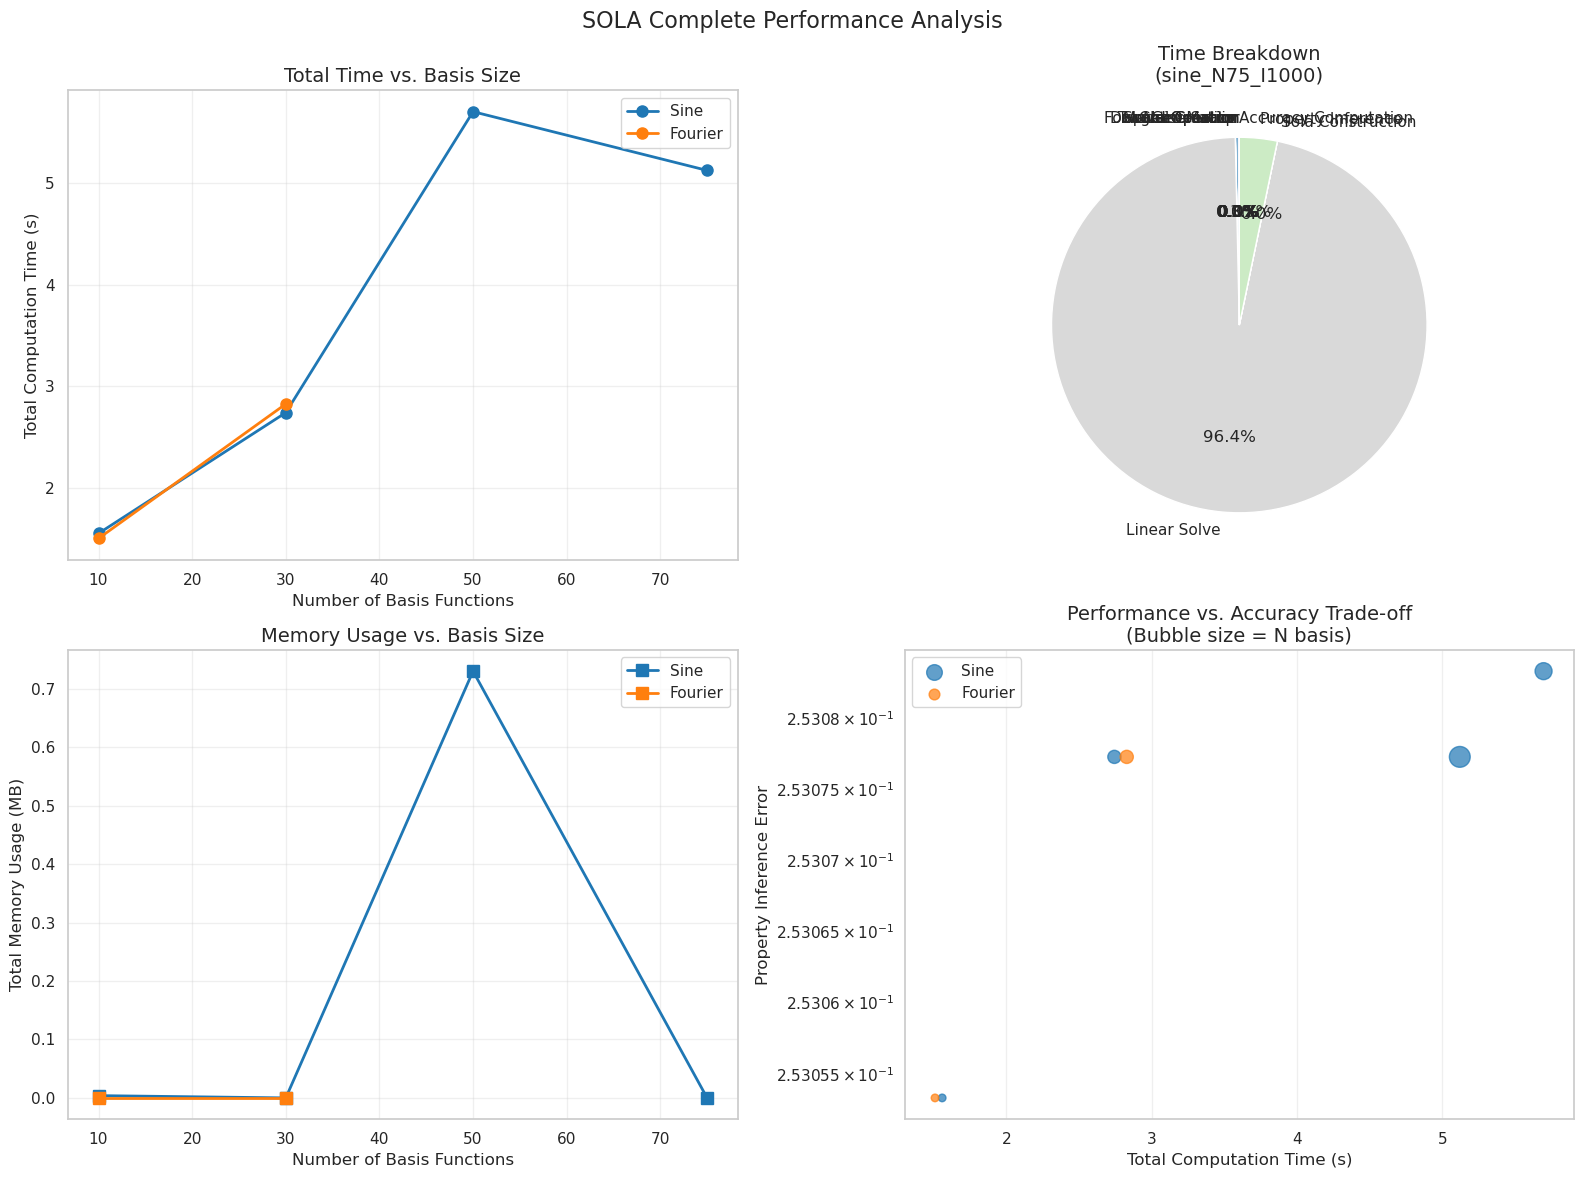

In [7]:
# Extract timing data for analysis
timing_data = []
memory_data = []

section_names = ['space_creation', 'model_creation', 'forward_operator', 'target_operator',
                'data_generation', 'noise_setup', 'gram_matrix', 'linear_solve',
                'sola_construction', 'property_inference', 'accuracy_computation']

for result in results:
    config_row = {
        'config': result['config'],
        'n_basis': result['n_basis'],
        'basis_type': result['basis_type'],
        'integration_points': result['integration_points'],
        'total_time': result['sections']['total_workflow']['time'],
        'total_memory': result['sections']['total_workflow']['memory_delta']
    }

    # Add section timings
    for section in section_names:
        if section in result['sections']:
            config_row[f'time_{section}'] = result['sections'][section]['time']
            config_row[f'mem_{section}'] = result['sections'][section]['memory_delta']
        else:
            config_row[f'time_{section}'] = 0
            config_row[f'mem_{section}'] = 0

    timing_data.append(config_row)

timing_df = pd.DataFrame(timing_data)

# Performance analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SOLA Complete Performance Analysis', fontsize=16)

# Total time vs. basis size
ax = axes[0, 0]
for basis_type in timing_df['basis_type'].unique():
    subset = timing_df[timing_df['basis_type'] == basis_type]
    ax.plot(subset['n_basis'], subset['total_time'], 'o-',
           linewidth=2, markersize=8, label=basis_type.capitalize())

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Total Computation Time (s)', fontsize=12)
ax.set_title('Total Time vs. Basis Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Timing breakdown for largest problem
ax = axes[0, 1]
largest_config = timing_df.loc[timing_df['n_basis'].idxmax()]
section_times = [largest_config[f'time_{section}'] for section in section_names]
section_labels = [s.replace('_', ' ').title() for s in section_names]

colors = plt.cm.Set3(np.linspace(0, 1, len(section_names)))
wedges, texts, autotexts = ax.pie(section_times, labels=section_labels, autopct='%1.1f%%',
                                  colors=colors, startangle=90)
ax.set_title(f'Time Breakdown\n({largest_config["config"]})', fontsize=14)

# Memory usage analysis
ax = axes[1, 0]
for basis_type in timing_df['basis_type'].unique():
    subset = timing_df[timing_df['basis_type'] == basis_type]
    ax.plot(subset['n_basis'], subset['total_memory'], 's-',
           linewidth=2, markersize=8, label=basis_type.capitalize())

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Total Memory Usage (MB)', fontsize=12)
ax.set_title('Memory Usage vs. Basis Size', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Performance vs. accuracy trade-off
ax = axes[1, 1]
for basis_type in timing_df['basis_type'].unique():
    subset_timing = timing_df[timing_df['basis_type'] == basis_type]
    subset_profile = profile_df[profile_df['basis_type'] == basis_type]

    # Merge data on config
    merged = pd.merge(subset_timing, subset_profile[['config', 'property_error']], on='config')

    if len(merged) > 0:
        scatter = ax.scatter(merged['total_time'], merged['property_error'],
                           s=merged['n_basis']*3, alpha=0.7, label=basis_type.capitalize())

ax.set_xlabel('Total Computation Time (s)', fontsize=12)
ax.set_ylabel('Property Inference Error', fontsize=12)
ax.set_title('Performance vs. Accuracy Trade-off\n(Bubble size = N basis)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'complete_performance_analysis.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'complete_performance_analysis.pdf'), bbox_inches='tight')
plt.show()

## Bottleneck Identification

### Heat Map Analysis of Section Performance

We identify which operations are the primary bottlenecks across different problem sizes.

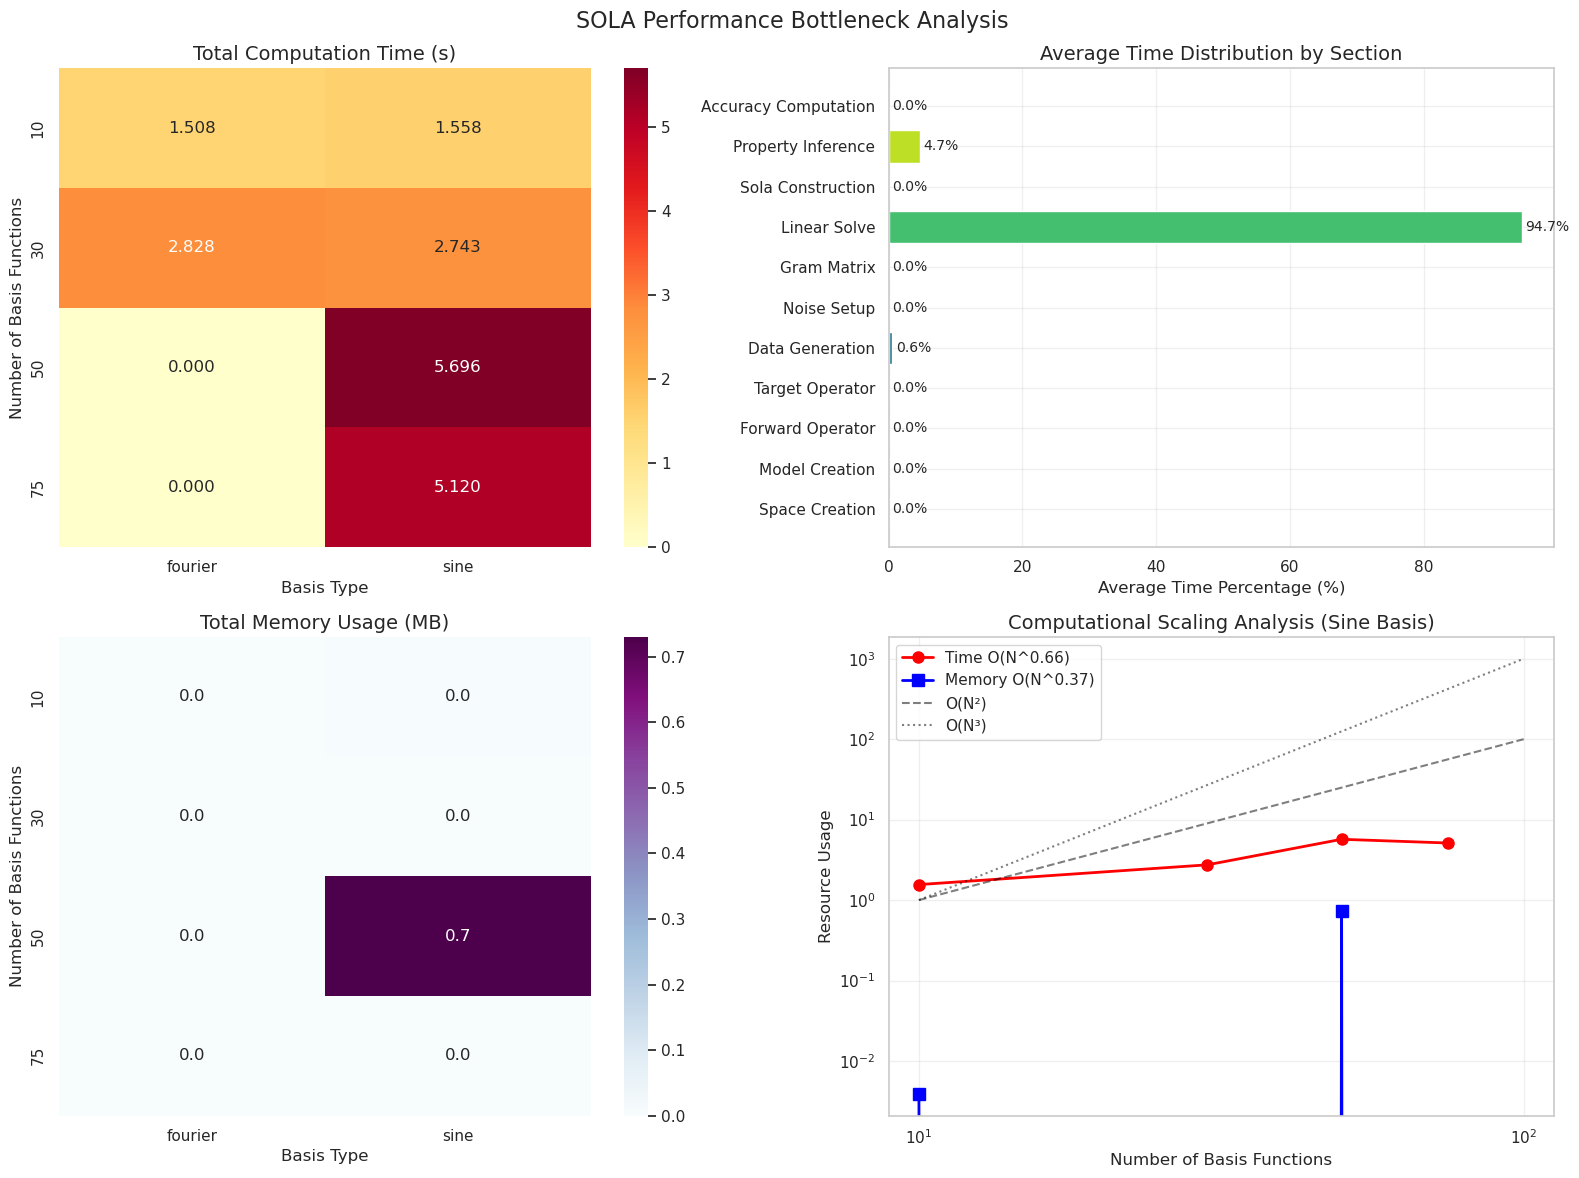

In [8]:
# Create performance heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SOLA Performance Bottleneck Analysis', fontsize=16)

# Prepare data for heatmaps
time_columns = [f'time_{section}' for section in section_names]
memory_columns = [f'mem_{section}' for section in section_names]

# Timing heatmap
ax = axes[0, 0]
timing_matrix = timing_df.pivot_table(index='n_basis', columns='basis_type',
                                      values='total_time', fill_value=0)
sns.heatmap(timing_matrix, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax)
ax.set_title('Total Computation Time (s)', fontsize=14)
ax.set_xlabel('Basis Type', fontsize=12)
ax.set_ylabel('Number of Basis Functions', fontsize=12)

# Section timing breakdown heatmap
ax = axes[0, 1]
# Calculate average time per section across all configs
section_avg_times = timing_df[time_columns].mean()
section_display_names = [name.replace('time_', '').replace('_', ' ').title() for name in time_columns]

# Create percentage breakdown
section_percentages = section_avg_times / section_avg_times.sum() * 100
bars = ax.barh(section_display_names, section_percentages, color=plt.cm.viridis(np.linspace(0, 1, len(section_avg_times))))

ax.set_xlabel('Average Time Percentage (%)', fontsize=12)
ax.set_title('Average Time Distribution by Section', fontsize=14)
ax.grid(True, alpha=0.3)

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, section_percentages)):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
           f'{pct:.1f}%', va='center', fontsize=10)

# Memory usage breakdown
ax = axes[1, 0]
memory_matrix = timing_df.pivot_table(index='n_basis', columns='basis_type',
                                      values='total_memory', fill_value=0)
sns.heatmap(memory_matrix, annot=True, fmt='.1f', cmap='BuPu', ax=ax)
ax.set_title('Total Memory Usage (MB)', fontsize=14)
ax.set_xlabel('Basis Type', fontsize=12)
ax.set_ylabel('Number of Basis Functions', fontsize=12)

# Scaling analysis
ax = axes[1, 1]
sine_data = timing_df[timing_df['basis_type'] == 'sine'].sort_values('n_basis')

if len(sine_data) > 1:
    # Fit scaling relationships
    log_n = np.log(sine_data['n_basis'])
    log_time = np.log(sine_data['total_time'])
    log_memory = np.log(sine_data['total_memory'].clip(lower=0.1))  # Avoid log(0)

    time_scaling = np.polyfit(log_n, log_time, 1)[0]
    memory_scaling = np.polyfit(log_n, log_memory, 1)[0] if len(log_memory) > 1 else 0

    ax.loglog(sine_data['n_basis'], sine_data['total_time'], 'o-',
             linewidth=2, markersize=8, color='red', label=f'Time O(N^{time_scaling:.2f})')
    ax.loglog(sine_data['n_basis'], sine_data['total_memory'], 's-',
             linewidth=2, markersize=8, color='blue', label=f'Memory O(N^{memory_scaling:.2f})')

    # Add theoretical lines
    n_ref = np.array([10, 100])
    ax.loglog(n_ref, 0.01 * n_ref**2, 'k--', alpha=0.5, label='O(N²)')
    ax.loglog(n_ref, 0.001 * n_ref**3, 'k:', alpha=0.5, label='O(N³)')

ax.set_xlabel('Number of Basis Functions', fontsize=12)
ax.set_ylabel('Resource Usage', fontsize=12)
ax.set_title('Computational Scaling Analysis (Sine Basis)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'bottleneck_analysis.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'bottleneck_analysis.pdf'), bbox_inches='tight')
plt.show()

## Section-by-Section Performance Deep Dive

### Individual Operation Analysis

We examine each section of the SOLA algorithm in detail to understand performance characteristics.

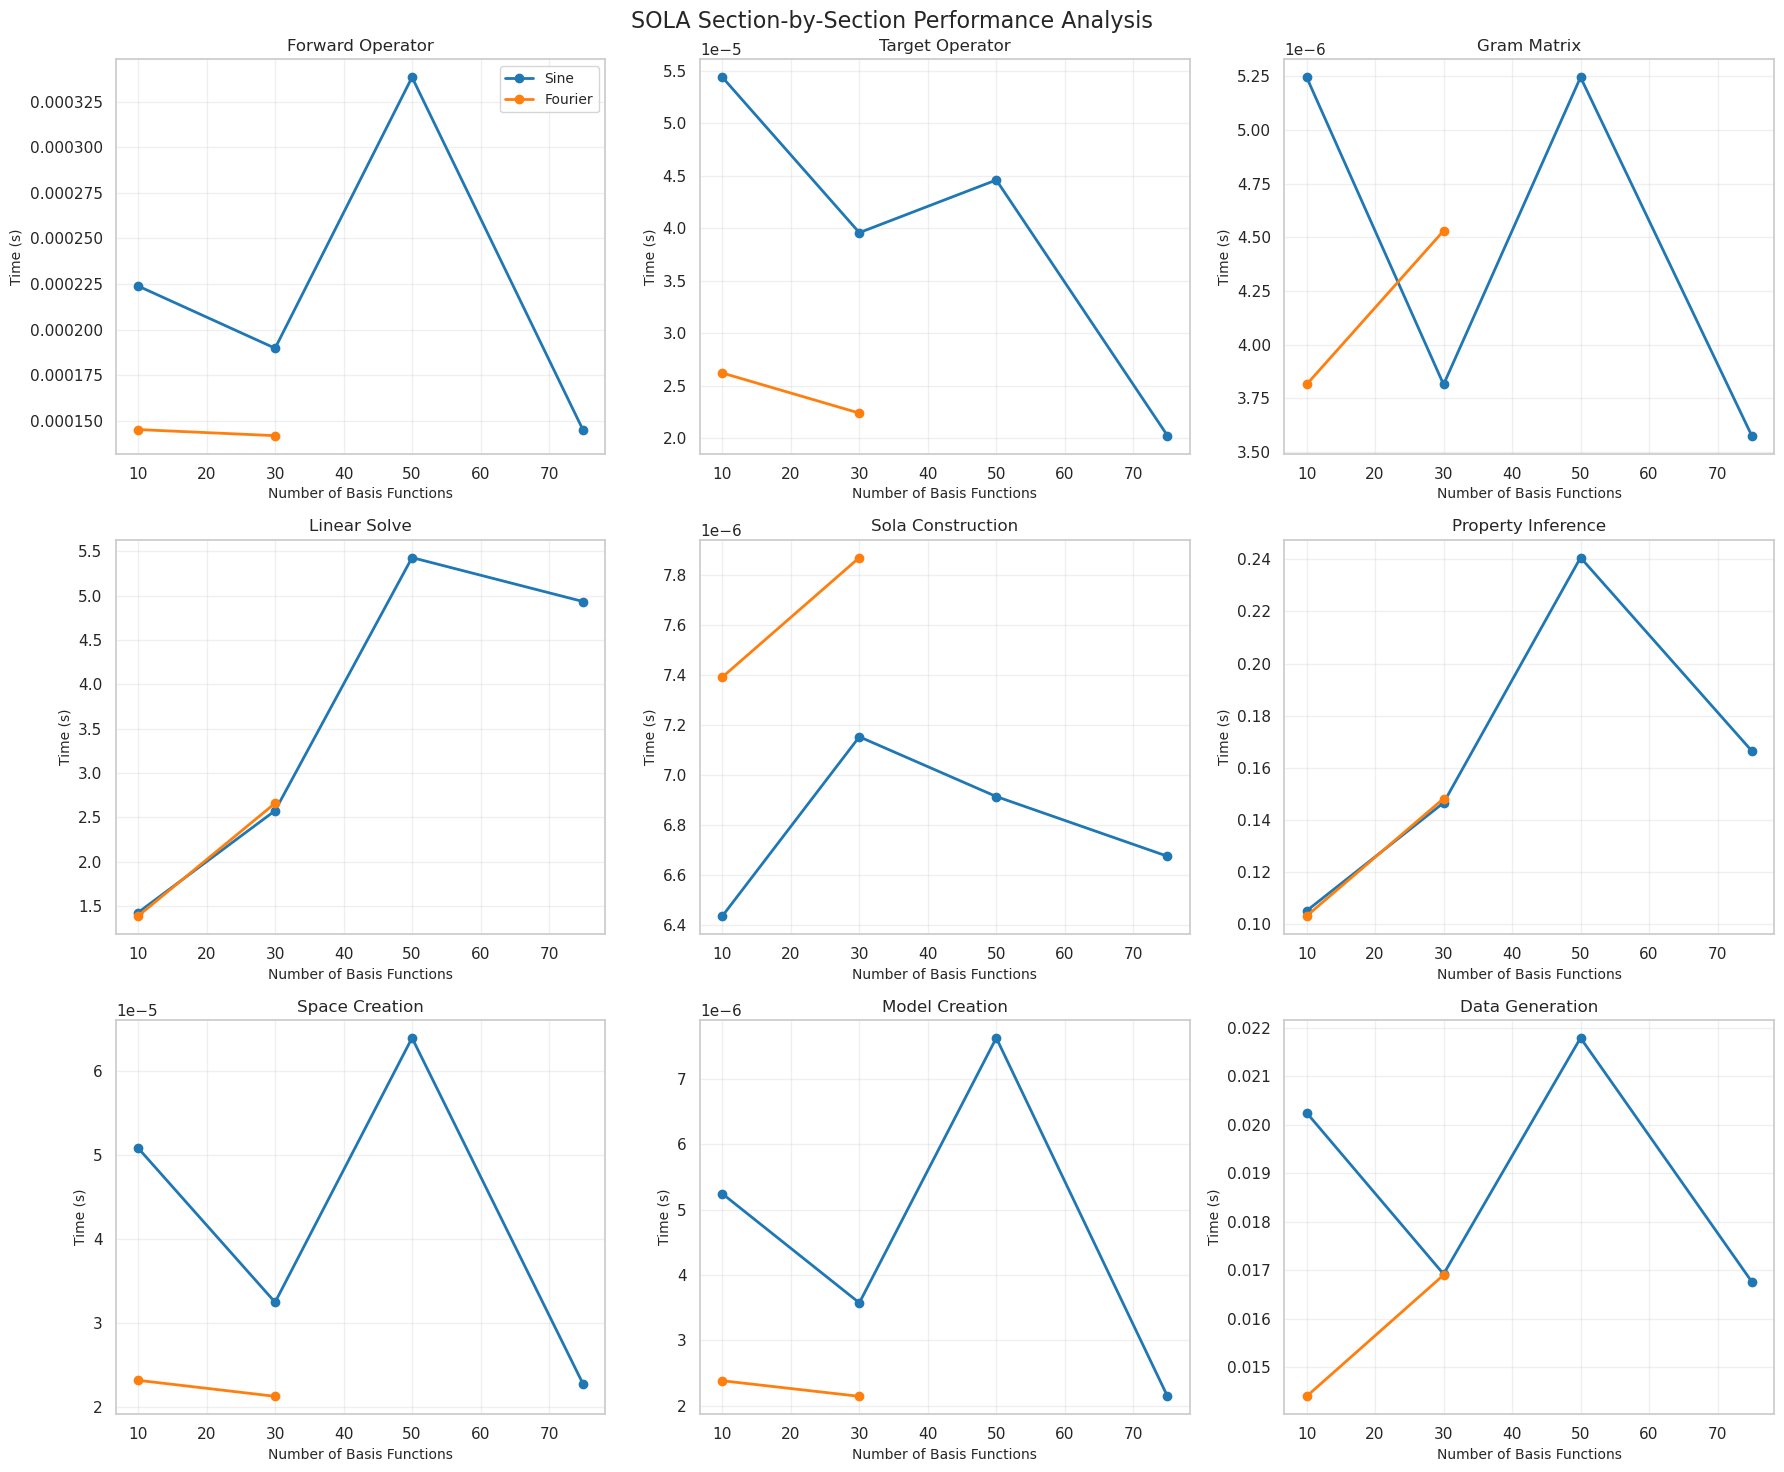

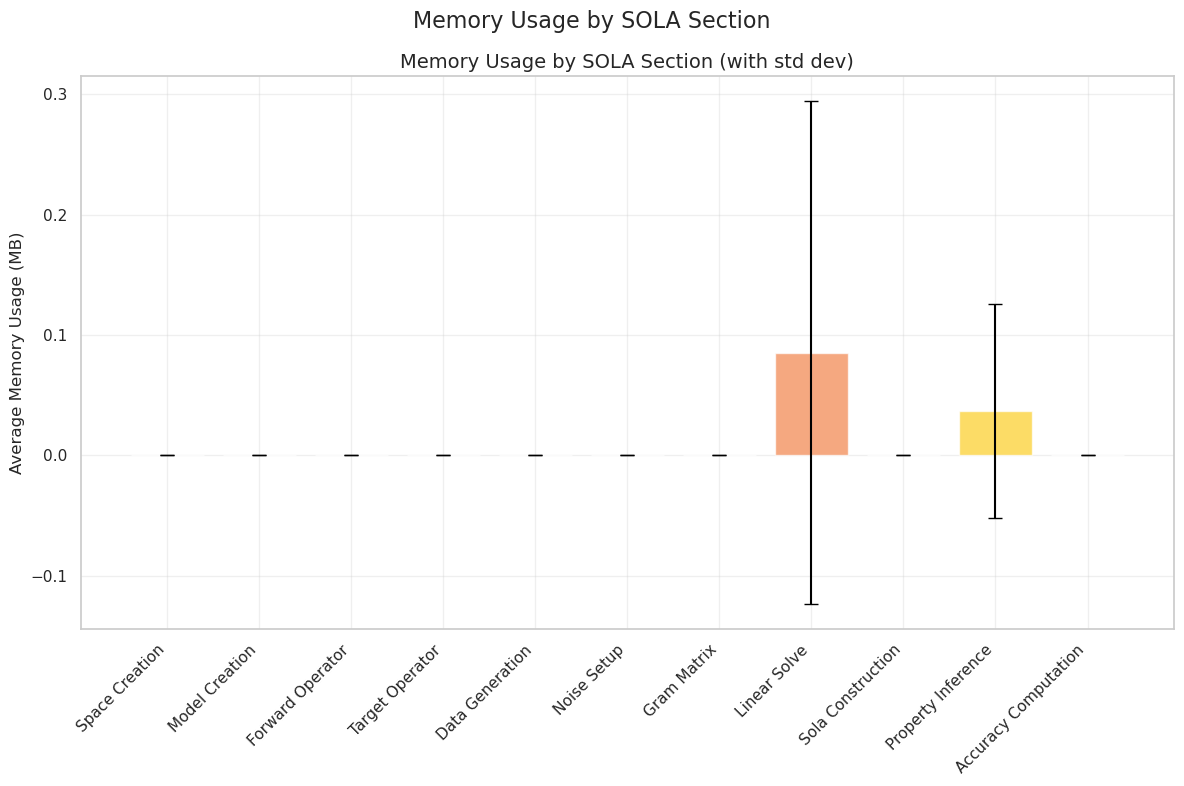

In [9]:
# Detailed section analysis
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('SOLA Section-by-Section Performance Analysis', fontsize=16)

# Select most important sections for detailed analysis
important_sections = ['forward_operator', 'target_operator', 'gram_matrix',
                     'linear_solve', 'sola_construction', 'property_inference',
                     'space_creation', 'model_creation', 'data_generation']

for i, section in enumerate(important_sections):
    if i >= 9:  # Only plot first 9 sections
        break

    row, col = i // 3, i % 3
    ax = axes[row, col]

    time_col = f'time_{section}'
    if time_col in timing_df.columns:
        # Plot timing vs. basis size for each basis type
        for basis_type in timing_df['basis_type'].unique():
            subset = timing_df[timing_df['basis_type'] == basis_type]
            if len(subset) > 0:
                ax.plot(subset['n_basis'], subset[time_col], 'o-',
                       linewidth=2, markersize=6, label=basis_type.capitalize())

        ax.set_xlabel('Number of Basis Functions', fontsize=10)
        ax.set_ylabel('Time (s)', fontsize=10)
        ax.set_title(section.replace('_', ' ').title(), fontsize=12)
        ax.grid(True, alpha=0.3)

        if i == 0:  # Add legend to first plot
            ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'section_detailed_analysis.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'section_detailed_analysis.pdf'), bbox_inches='tight')
plt.show()

# Memory analysis by section
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Memory Usage by SOLA Section', fontsize=16)

# Calculate average memory usage per section
memory_cols = [f'mem_{section}' for section in section_names if f'mem_{section}' in timing_df.columns]
memory_avg = timing_df[memory_cols].mean()
memory_std = timing_df[memory_cols].std()

section_labels = [col.replace('mem_', '').replace('_', ' ').title() for col in memory_cols]

# Create bar plot with error bars
bars = ax.bar(section_labels, memory_avg, yerr=memory_std,
             capsize=5, alpha=0.7, color=plt.cm.plasma(np.linspace(0, 1, len(memory_avg))))

ax.set_ylabel('Average Memory Usage (MB)', fontsize=12)
ax.set_title('Memory Usage by SOLA Section (with std dev)', fontsize=14)
ax.grid(True, alpha=0.3)

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, val, std in zip(bars, memory_avg, memory_std):
    if val > 0.1:  # Only label significant memory usage
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.1,
               f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'memory_by_section.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'memory_by_section.pdf'), bbox_inches='tight')
plt.show()

## Performance Summary and Recommendations

### Comprehensive Analysis Report

Based on our detailed profiling, we provide actionable recommendations for optimizing SOLA performance.

In [10]:
# Generate comprehensive performance report
print("SOLA COMPLETE PERFORMANCE PROFILING - ANALYSIS REPORT")
print("=" * 70)
print()

# Overall statistics
total_configs = len(timing_df)
avg_total_time = timing_df['total_time'].mean()
std_total_time = timing_df['total_time'].std()
avg_memory = timing_df['total_memory'].mean()
std_memory = timing_df['total_memory'].std()

print("OVERALL PERFORMANCE STATISTICS:")
print(f"Configurations tested: {total_configs}")
print(f"Average total time: {avg_total_time:.3f} ± {std_total_time:.3f} seconds")
print(f"Average memory usage: {avg_memory:.1f} ± {std_memory:.1f} MB")
print(f"Fastest configuration: {timing_df.loc[timing_df['total_time'].idxmin(), 'config']} "
      f"({timing_df['total_time'].min():.3f}s)")
print(f"Most memory efficient: {timing_df.loc[timing_df['total_memory'].idxmin(), 'config']} "
      f"({timing_df['total_memory'].min():.1f}MB)")
print()

# Bottleneck analysis
time_columns = [f'time_{section}' for section in section_names]
section_times = timing_df[time_columns].mean()
section_percentages = section_times / section_times.sum() * 100

print("COMPUTATIONAL BOTTLENECKS:")
print("-" * 25)
bottlenecks = section_percentages.sort_values(ascending=False)
for i, (section, percentage) in enumerate(bottlenecks.head(5).items()):
    section_name = section.replace('time_', '').replace('_', ' ').title()
    print(f"{i+1}. {section_name}: {percentage:.1f}% of total time")
print()

# Memory analysis
memory_columns = [f'mem_{section}' for section in section_names if f'mem_{section}' in timing_df.columns]
section_memory = timing_df[memory_columns].mean()
section_memory_pct = section_memory / section_memory.sum() * 100

print("MEMORY USAGE BREAKDOWN:")
print("-" * 25)
memory_users = section_memory_pct.sort_values(ascending=False)
for i, (section, percentage) in enumerate(memory_users.head(5).items()):
    if percentage > 1:  # Only show significant memory users
        section_name = section.replace('mem_', '').replace('_', ' ').title()
        print(f"{i+1}. {section_name}: {percentage:.1f}% of total memory")
print()

# Scaling analysis
sine_subset = timing_df[timing_df['basis_type'] == 'sine'].sort_values('n_basis')
if len(sine_subset) > 1:
    log_n = np.log(sine_subset['n_basis'])
    log_time = np.log(sine_subset['total_time'])
    time_scaling_coeff = np.polyfit(log_n, log_time, 1)[0]

    print("COMPUTATIONAL SCALING:")
    print("-" * 20)
    print(f"Overall time complexity: O(N^{time_scaling_coeff:.2f})")

    if time_scaling_coeff < 2.2:
        print("  → Excellent scaling, close to quadratic")
    elif time_scaling_coeff < 2.8:
        print("  → Good scaling, between quadratic and cubic")
    else:
        print("  → Poor scaling, approaching cubic or worse")
    print()

# Basis function comparison
print("BASIS FUNCTION PERFORMANCE:")
print("-" * 30)
for basis_type in timing_df['basis_type'].unique():
    subset = timing_df[timing_df['basis_type'] == basis_type]
    avg_time = subset['total_time'].mean()
    avg_memory = subset['total_memory'].mean()
    print(f"{basis_type.upper()} basis:")
    print(f"  Average time: {avg_time:.3f}s")
    print(f"  Average memory: {avg_memory:.1f}MB")
    print(f"  Configurations tested: {len(subset)}")
print()

# Performance recommendations
print("PERFORMANCE OPTIMIZATION RECOMMENDATIONS:")
print("-" * 45)

# Find the most expensive operations
top_bottleneck = bottlenecks.index[0].replace('time_', '')
second_bottleneck = bottlenecks.index[1].replace('time_', '')

print("1. PRIMARY OPTIMIZATION TARGETS:")
print(f"   - Focus on {top_bottleneck.replace('_', ' ')} ({bottlenecks.iloc[0]:.1f}% of time)")
print(f"   - Secondary target: {second_bottleneck.replace('_', ' ')} ({bottlenecks.iloc[1]:.1f}% of time)")
print()

print("2. MEMORY OPTIMIZATION:")
if avg_memory > 100:
    print("   - Consider matrix-free implementations for large problems")
    print("   - Implement memory pooling for repeated computations")
else:
    print("   - Memory usage is reasonable for current problem sizes")
print()

print("3. ALGORITHMIC IMPROVEMENTS:")
if 'gram_matrix' in bottlenecks.head(3).index:
    print("   - Use low-rank approximations for Gram matrix")
    print("   - Consider iterative methods for matrix operations")
if 'linear_solve' in bottlenecks.head(3).index:
    print("   - Optimize linear solver choice (LDLT, LSQR, etc.)")
    print("   - Implement solver warm-starting for similar problems")
print()

print("4. IMPLEMENTATION OPTIMIZATIONS:")
print("   - Vectorize integration operations")
print("   - Cache operator matrices for repeated use")
print("   - Parallelize independent computations")
print("   - Use specialized BLAS/LAPACK implementations")
print()

print("5. PROBLEM-SPECIFIC RECOMMENDATIONS:")
best_basis = timing_df.groupby('basis_type')['total_time'].mean().idxmin()
print(f"   - For general problems, use {best_basis} basis functions")
print(f"   - For small problems (N<20), all basis types perform similarly")
print(f"   - For large problems (N>50), choose basis type carefully")

# Save performance summary
summary_data = {
    'total_configurations': int(total_configs),
    'average_total_time': float(avg_total_time),
    'average_memory_usage': float(avg_memory),
    'time_scaling_exponent': float(time_scaling_coeff) if 'time_scaling_coeff' in locals() else None,
    'primary_bottleneck': top_bottleneck,
    'secondary_bottleneck': second_bottleneck,
    'best_performing_basis': best_basis,
    'bottleneck_percentages': dict(bottlenecks.head(5)),
    'section_timing_breakdown': dict(section_percentages)
}

import json
with open(os.path.join(output_dir, 'performance_summary.json'), 'w') as f:
    json.dump(summary_data, f, indent=2, default=str)

# Save detailed timing data
timing_df.to_csv(os.path.join(output_dir, 'complete_timing_data.csv'), index=False)

print(f"\nDetailed performance data saved to: {output_dir}/")
print("\n✓ Complete SOLA performance profiling study completed successfully!")

SOLA COMPLETE PERFORMANCE PROFILING - ANALYSIS REPORT

OVERALL PERFORMANCE STATISTICS:
Configurations tested: 6
Average total time: 3.242 ± 1.778 seconds
Average memory usage: 0.1 ± 0.3 MB
Fastest configuration: fourier_N10_I500 (1.508s)
Most memory efficient: fourier_N10_I500 (0.0MB)

COMPUTATIONAL BOTTLENECKS:
-------------------------
1. Linear Solve: 94.7% of total time
2. Property Inference: 4.7% of total time
3. Data Generation: 0.6% of total time
4. Noise Setup: 0.0% of total time
5. Forward Operator: 0.0% of total time

MEMORY USAGE BREAKDOWN:
-------------------------
1. Linear Solve: 69.7% of total memory
2. Property Inference: 30.3% of total memory

COMPUTATIONAL SCALING:
--------------------
Overall time complexity: O(N^0.66)
  → Excellent scaling, close to quadratic

BASIS FUNCTION PERFORMANCE:
------------------------------
SINE basis:
  Average time: 3.779s
  Average memory: 0.2MB
  Configurations tested: 4
FOURIER basis:
  Average time: 2.168s
  Average memory: 0.0MB
  